# Central Line: Probe Orientation Classifier

This notebook contains all the code neccesary to train and test the overall probe orientation classifier.

---
 
## Define user parameters

In [1]:
#Preprocessing paths
preprocessing_input_dir = r"C:\repos\aigt\DeepLearnLive\Datasets\US_Vessel_Segmentations"
preprocessing_output_dir = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\ClassifierDataNp"

#Classifier paths
unet_path = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\IMNO Outputs\Central_Line_UNet_fold_0_2020-12-04_18-38-12"
data_input_dir = r"C:\Users\cbarr\OneDrive - Queen's University\Grad School\Courses\CISC 881\Project\Data\ClassifierDataNp"

#Learning parameters
image_size = 128

#Testing set participant indices
test_idx = [15,16,17,18,19]

---

## Imports

In [2]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import datetime
from ipywidgets import IntProgress
from IPython.display import display, HTML
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPool2D, Input, GlobalAveragePooling2D, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import classification_report, accuracy_score

---

## Preprocess data

Process label and US image data, exporting to numpy arrays by sequence

In [27]:
#Get all sequence names
sequence_names = [name for name in os.listdir(preprocessing_input_dir)]

#Returns the US images resizes to output_size and scaled to their max intensity
def process_us(us_img, output_size):
    resized_img = cv2.resize(us_img, (output_size, output_size)).astype(np.float16)
    return resized_img / resized_img.max()

#Returns a 3D stack of processed US images
def accumulate_and_process(all_img_paths, processing_fxn, output_size, f): 
    data = np.array([], dtype=np.float64).reshape(output_size, output_size, 0)
    for idx, img_path in enumerate(all_img_paths):        #Go through all images in folder
        f.value = idx                                     #Update value of loading bar
        img = cv2.imread(os.path.abspath(img_path), 0)    #Read in an image
        processed_img = processing_fxn(img, output_size)  #Process the image
        data = np.dstack((data, processed_img))           #Add the image to the stack
    return data

#Go through all sequences
for seq in sequence_names:
    
    print("current sequence name: " + seq)
    
    #Get all png image paths within the folder.
    us_paths = list(Path(preprocessing_input_dir + "\\" + seq).glob(seq+"_[0-9][0-9][0-9][0-9][0-9].png"))
    
    #Update a progress bar
    f_us = IntProgress(min=0, max=len(us_paths))                    
    print(seq + " Ultrasound processing progress: ")
    display(f_us)
                         
    #Accumulate and process images
    us_data = accumulate_and_process(us_paths, process_us, image_size, f_us)
    
    #Read in the labels for this data
    labels_path = os.path.join((preprocessing_input_dir + "\\" + seq), (seq+"_Labels.csv"))
    labels_df = pd.read_csv(labels_path)
    
    #Save the numpy files
    output_us_path = os.path.join(preprocessing_output_dir, seq +"_ultrasound" )
    output_seg_path = os.path.join(preprocessing_output_dir, seq+"_label" )
    np.save(output_us_path, us_data)
    np.save(output_seg_path, labels_df)

current sequence name: MS01-20200210-132740
MS01-20200210-132740 Ultrasound processing progress: 


IntProgress(value=0, max=1749)

current sequence name: MS01-20200210-133541
MS01-20200210-133541 Ultrasound processing progress: 


IntProgress(value=0, max=1123)

current sequence name: MS01-20200210-134522
MS01-20200210-134522 Ultrasound processing progress: 


IntProgress(value=0, max=1088)

current sequence name: MS01-20200210-135109
MS01-20200210-135109 Ultrasound processing progress: 


IntProgress(value=0, max=1005)

current sequence name: MS01-20200210-135709
MS01-20200210-135709 Ultrasound processing progress: 


IntProgress(value=0, max=830)

current sequence name: MS02-20200210-152131
MS02-20200210-152131 Ultrasound processing progress: 


IntProgress(value=0, max=1319)

current sequence name: MS02-20200210-152827
MS02-20200210-152827 Ultrasound processing progress: 


IntProgress(value=0, max=1059)

current sequence name: MS02-20200210-153709
MS02-20200210-153709 Ultrasound processing progress: 


IntProgress(value=0, max=979)

current sequence name: MS02-20200210-154411
MS02-20200210-154411 Ultrasound processing progress: 


IntProgress(value=0, max=833)

current sequence name: MS02-20200210-160404
MS02-20200210-160404 Ultrasound processing progress: 


IntProgress(value=0, max=1389)

current sequence name: MS03-20200213-152826
MS03-20200213-152826 Ultrasound processing progress: 


IntProgress(value=0, max=1218)

current sequence name: MS03-20200213-153647
MS03-20200213-153647 Ultrasound processing progress: 


IntProgress(value=0, max=1214)

current sequence name: MS03-20200213-154347
MS03-20200213-154347 Ultrasound processing progress: 


IntProgress(value=0, max=1076)

current sequence name: MS03-20200213-155250
MS03-20200213-155250 Ultrasound processing progress: 


IntProgress(value=0, max=1256)

current sequence name: MS03-20200213-155823
MS03-20200213-155823 Ultrasound processing progress: 


IntProgress(value=0, max=663)

current sequence name: MS04-20200213-173406
MS04-20200213-173406 Ultrasound processing progress: 


IntProgress(value=0, max=1663)

current sequence name: MS04-20200213-174259
MS04-20200213-174259 Ultrasound processing progress: 


IntProgress(value=0, max=1188)

current sequence name: MS04-20200213-175619
MS04-20200213-175619 Ultrasound processing progress: 


IntProgress(value=0, max=1070)

current sequence name: MS04-20200213-180237
MS04-20200213-180237 Ultrasound processing progress: 


IntProgress(value=0, max=1120)

current sequence name: MS04-20200213-180907
MS04-20200213-180907 Ultrasound processing progress: 


IntProgress(value=0, max=1070)

---

## Read in data

In [3]:
#Read the US image and segmentations paths into lists
label_files = list(sorted(Path(data_input_dir).glob("*_label.npy")))
us_files = list(sorted(Path(data_input_dir).glob("*_ultrasound.npy")))

#Go through all file paths in both arrays and append to list
us_data_by_seq = []
label_by_seq = []
for i in range(len(us_files)):
    
    #Load the current files as 3D numpy arrays
    us_np = np.load(os.path.abspath(us_files[i]))
    label_np = np.load(os.path.abspath(label_files[i]), allow_pickle=True)
    
    #Normalize and add channel dimension
    us_np = us_np[...,np.newaxis] / 255
    
    #Append to the collector lists.
    us_data_by_seq.append(us_np.transpose(2,1,0,3))
    label_by_seq.append(label_np[:,4])
    
#Verify that the total number of segmentation images matches the total number of us images.
for idx in range(len(us_data_by_seq)):
    if label_by_seq[idx].shape[0] != us_data_by_seq[idx].shape[0]:
        print("Data Problem: Dataset {} has {} ultrasounds and {} labels". format(
            idx, us_data_by_seq[idx].shape[0], len(label_by_seq[idx])))

---

## Seperate into training / validation / testing sets

In [4]:
#Create lists of indices for training and validation sets
trainAndVal_idx = list(range(len(us_data_by_seq)))
trainAndVal_idx = [x for x in trainAndVal_idx if x not in test_idx] #Remove IDs

#Extract and concatenate the labels for train / test / val
y_trainAndVal = np.concatenate(np.take(label_by_seq, trainAndVal_idx), axis=0)
y_test = np.concatenate(np.take(label_by_seq, test_idx), axis=0)

#Extract and concatenate the ultrasound images for train / test / val
X_trainAndVal = np.concatenate(np.take(us_data_by_seq, trainAndVal_idx), axis=0)
X_test = np.concatenate(np.take(us_data_by_seq, test_idx), axis=0)

#Extract training and validation sets from trainAndVal using 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X_trainAndVal, y_trainAndVal, test_size=0.2, random_state=2)

#get rid of any nans
y_train[pd.isnull(y_train)] = 'Undefined'
y_val[pd.isnull(y_val)] = 'Undefined'
y_test[pd.isnull(y_test)] = 'Undefined'

#onehot encode the labels
encoder = OneHotEncoder(handle_unknown='ignore')
y_train = encoder.fit_transform(y_train.reshape(-1,1)).toarray()
y_val = encoder.fit_transform(y_val.reshape(-1,1)).toarray()
y_test = encoder.fit_transform(y_test.reshape(-1,1)).toarray()

print("Trained on {} images, validated on {} images, tested on {} images.".format(X_train.shape[0],
                                                                                 X_val.shape[0],
                                                                                 X_test.shape[0]))

C:\repos\dlenv\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Trained on 13440 images, validated on 3361 images, tested on 6111 images.


---

## Define network architecture

In [5]:
#Read in the unet model and freeze weights
unet_model =  tf.keras.models.load_model(unet_path, compile=False)
unet_model.trainable = False

#Input layer; takes in US image
input_layer = Input(shape=(image_size, image_size, 1))

#Unet Layer; takes image, return segmentation
unet_layer = unet_model(inputs=input_layer)

#First convolutional layer; recieves both segmentations from U-Net
cov2d_1 = Conv2D(8, (3, 3), activation='relu')(unet_layer)  

#Second convolutional layer
cov2d_2 = Conv2D(8, (3, 3), activation='relu')(cov2d_1)  

#Max pool layer
pl = MaxPool2D((3, 3))(cov2d_2)   

#Flatten layer
fl = Flatten()(pl)

#First dense layer
d1 = Dense(64, activation='relu')(fl)

#Dense layer with softmax activation
d2 = Dense(3, activation='softmax')(d1)

#Build the model from the input and output layers
model = tf.keras.Model(
    inputs=input_layer,
    outputs=d2,
)

#Compile the model
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 1)]     0         
_________________________________________________________________
model (Model)                (None, 128, 128, 2)       304902    
_________________________________________________________________
conv2d (Conv2D)              (None, 126, 126, 8)       152       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 8)       584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 41, 8)         0         
_________________________________________________________________
flatten (Flatten)            (None, 13448)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                860736

---

## Train the model

In [6]:
history = model.fit(x=X_train, 
                    y=y_train, 
                    validation_data=(X_val, y_val),
                    batch_size=300,
                    epochs=10,
                    verbose=1,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3, restore_best_weights=True)
                    ]
)

Train on 13440 samples, validate on 3361 samples
Epoch 1/10
13440/13440 [==============================] - 115s 9ms/sample - loss: 0.4307 - accuracy: 0.8627 - val_loss: 0.2114 - val_accuracy: 0.9393
Epoch 2/10
13440/13440 [==============================] - 111s 8ms/sample - loss: 0.1899 - accuracy: 0.9529 - val_loss: 0.1938 - val_accuracy: 0.9491
Epoch 3/10
13440/13440 [==============================] - 110s 8ms/sample - loss: 0.1765 - accuracy: 0.9576 - val_loss: 0.1813 - val_accuracy: 0.9554
Epoch 4/10
13440/13440 [==============================] - 111s 8ms/sample - loss: 0.1647 - accuracy: 0.9597 - val_loss: 0.1783 - val_accuracy: 0.9551
Epoch 5/10
13440/13440 [==============================] - 112s 8ms/sample - loss: 0.1559 - accuracy: 0.9626 - val_loss: 0.1676 - val_accuracy: 0.9598
Epoch 6/10
13440/13440 [==============================] - 112s 8ms/sample - loss: 0.1486 - accuracy: 0.9647 - val_loss: 0.1680 - val_accuracy: 0.9598
Epoch 7/10
13440/13440 [===========================

---

## Evaluate the model performance on the test set

In [7]:
results = model.evaluate(X_test, y_test, batch_size=300)

6111/6111 [==============================] - 23s 4ms/sample - loss: 0.3318 - accuracy: 0.9383


---

## Print test set statistics

In [20]:
#Get test set predictions
test_pred = model.predict(X_test)
test_pred_labels = tf.argmax(test_pred, axis=1)
test_actual_labels = tf.argmax(y_test, axis=1)
num_classes = 3

#Get the classification report for the 3 pose classes
target_names = ['Cross-section', 'Long-axis', 'Undefined']
print(classification_report(test_actual_labels, test_pred_labels, target_names=target_names))

               precision    recall  f1-score   support

Cross-section       0.93      0.92      0.92      2279
    Long-axis       0.74      0.52      0.61       284
    Undefined       0.94      0.97      0.96      3548

     accuracy                           0.93      6111
    macro avg       0.87      0.80      0.83      6111
 weighted avg       0.93      0.93      0.93      6111



---

## Generate test set confusion matrix

Normalized confusion matrix
[[0.91794647 0.01491882 0.06713471]
 [0.28521127 0.52112676 0.19366197]
 [0.02085682 0.00535513 0.97378805]]


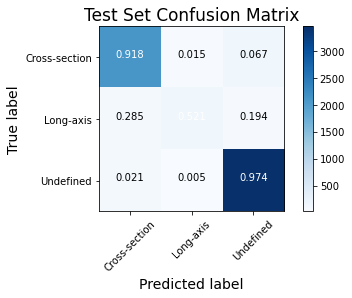

In [23]:
#Generate confusion matrix
confusion_matrix = tf.math.confusion_matrix(test_actual_labels, test_pred_labels , 3)

#Specify plot properties
plt.rc('font', size=10)         
plt.rc('axes', titlesize=17)    
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=10)    
plt.rc('ytick', labelsize=10)   
plt.rc('legend', fontsize=10)   
plt.rc('figure', titlesize=17)  

#Define function for printing a confusion matrix
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues,
                        save_fig = False):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 3),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save_fig:
        plt.savefig("Confusion_Matrix.pdf", bbox_inches = "tight")

#Print the confusion matrix
plot_confusion_matrix(confusion_matrix.numpy(), 
                      ["Cross-section", "Long-axis", "Undefined"], 
                      normalize=True,
                     title='Test Set Confusion Matrix',
                     save_fig=False)